In [1]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
# Basic Libraries

import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

# Libraries for Classification and building Models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Project Specific Libraries

import os
import librosa
import librosa.display
import glob 
import skimage

In [3]:
#Using Librosa to analyse random sound sample - SPECTOGRAM
dat1, sampling_rate1 = librosa.load('../input/cough-audio-dataset/data_audio/data/coughs/esc_13.wav')
dat2, sampling_rate2 = librosa.load('../input/cough-audio-dataset/data_audio/data/not_coughs/audioset_1.wav')

In [4]:
#pip install pydub ffmpeg-python
cough = '../input/cough-audio-dataset/data_audio/data/coughs/esc_13.wav'
non_cough = '../input/cough-audio-dataset/data_audio/data/not_coughs/audioset_1.wav'

from pydub import AudioSegment
import IPython
path = cough
IPython.display.Audio(path)

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

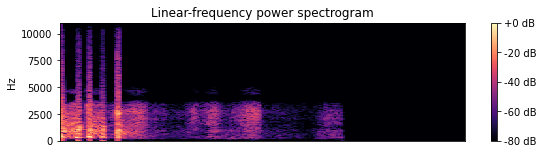

In [5]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

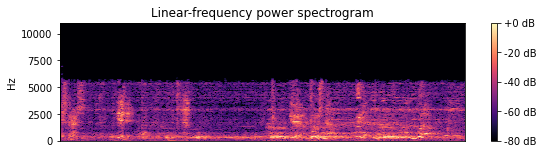

In [6]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

## Feature Extraction and Database Building

**Method**

 - I have used Librosa to extract features.
 - To do so, I will go through each fold and extract the data for each file. Then I have used the mel_spectogram function of librosa to extract the spectogram data as a numpy array.
 - After reshaping and cleaning the data, 75-25 split has been performed.
 - Classes (Y) have been converted to Categorically Encoded Data using Keras.utils

In [7]:
'''EXAMPLE'''

dat1, sampling_rate1 = librosa.core.load('../input/cough-audio-dataset/data_audio/data/coughs/esc_19.wav')
arr = librosa.feature.melspectrogram(y=dat1, sr=sampling_rate1)
arr.shape

(128, 216)

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

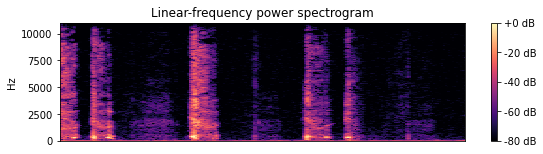

In [8]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [9]:
h = pd.DataFrame(arr.T)
h

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,3.345603,1.161430,0.152177,0.030125,0.006054,0.034378,0.322443,0.078908,0.017763,0.087815,...,0.200547,0.128397,0.060461,0.023871,0.000755,5.703168e-03,0.033526,0.006827,6.051871e-03,4.309317e-04
1,2.288082,0.592775,0.106459,0.014208,0.013564,0.061614,0.220952,0.190879,0.162627,0.168778,...,0.127330,0.069077,0.080324,0.052817,0.002640,5.738045e-03,0.014643,0.004631,3.695280e-03,2.329303e-04
2,1.238117,0.209205,0.042964,0.015138,0.025722,0.016952,0.069300,0.284846,0.272376,0.162274,...,0.036152,0.027898,0.053737,0.058429,0.003811,2.940001e-03,0.003587,0.001858,3.116109e-03,2.547977e-04
3,0.209182,0.080462,0.012752,0.015737,0.011267,0.003276,0.040017,0.105160,0.071594,0.084896,...,0.018909,0.032291,0.014316,0.012421,0.001069,6.238575e-04,0.002760,0.000294,1.332190e-03,1.393594e-04
4,0.099454,0.025175,0.012180,0.006776,0.014065,0.002666,0.008080,0.022483,0.055303,0.185989,...,0.013885,0.026640,0.006378,0.001068,0.000066,3.365652e-04,0.001862,0.000112,1.296818e-04,2.145300e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,0.119765,0.008521,0.000165,0.000131,0.000058,0.000029,0.000019,0.000017,0.000009,0.000010,...,0.000002,0.000002,0.000001,0.000002,0.000002,1.270721e-06,0.000002,0.000001,7.901710e-07,4.461353e-08
212,0.237821,0.015356,0.000483,0.000036,0.000085,0.000053,0.000026,0.000038,0.000008,0.000021,...,0.000002,0.000002,0.000002,0.000002,0.000002,8.881143e-07,0.000001,0.000001,4.649262e-07,3.597248e-08
213,0.294460,0.015487,0.000476,0.000090,0.000105,0.000027,0.000025,0.000035,0.000014,0.000021,...,0.000002,0.000002,0.000002,0.000001,0.000002,1.573125e-06,0.000002,0.000002,4.913638e-07,3.862723e-08
214,0.250920,0.021736,0.000510,0.000225,0.000084,0.000031,0.000020,0.000019,0.000020,0.000020,...,0.000003,0.000002,0.000002,0.000002,0.000003,2.691073e-06,0.000003,0.000002,6.964470e-07,4.024943e-08


## Parsing through the entire directory to get files list along with the type of recording

In [10]:
#Creating CSV file consisting of file path and type of cough
import glob
cough_list = glob.glob("../input/cough-audio-dataset/data_audio/data/coughs/*.wav")
not_cough_list = glob.glob("../input/cough-audio-dataset/data_audio/data/not_coughs/*.wav")

cough_df = pd.DataFrame(columns=['path','type'])
not_cough_df = pd.DataFrame(columns=['path','type'])
cough_df['path'] = cough_list
not_cough_df['path'] = not_cough_list
cough_df['type'] = 1
not_cough_df['type'] = 0
files_data = cough_df.append(not_cough_df, ignore_index=True)

In [11]:
files_data

,path,type
0,../input/cough-audio-dataset/data_audio/data/c...,1
1,../input/cough-audio-dataset/data_audio/data/c...,1
2,../input/cough-audio-dataset/data_audio/data/c...,1
3,../input/cough-audio-dataset/data_audio/data/c...,1
4,../input/cough-audio-dataset/data_audio/data/c...,1
...,...,...
13239,../input/cough-audio-dataset/data_audio/data/n...,0
13240,../input/cough-audio-dataset/data_audio/data/n...,0
13241,../input/cough-audio-dataset/data_audio/data/n...,0
13242,../input/cough-audio-dataset/data_audio/data/n...,0


In [12]:
files_data[files_data['type'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 431 entries, 0 to 430
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    431 non-null    object
 1   type    431 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.1+ KB


In [13]:
# !pip install sweetviz
# import sweetviz
# import pandas as pd
# df = files_data
# my_report  = sweetviz.analyze([df,'Train'], target_feat='type')
# my_report.show_notebook(w=1500, h=300, scale=0.8)

## Data Augmentation

**Two Methods:**
- Waveform Augmentation
- Spectogram Augmentation

*Note:*
- Type 1: Cough
- Type 0: Non-Cough

In [14]:
# feature = []
# file_name = '../input/cough-audio-dataset/data_audio/data/coughs/audioset_106.wav'
# X, sample_rate = librosa.load(file_name) 
# # We extract mfcc feature from data
# mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
# feature.append(mels)

In [15]:
feature = []
label = []

def parser(data):
    # Function to load files and extract features
    for i in range(len(data)):
        file_name = data['path'][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name) 
        # We extract mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(data['type'][i])
    return [feature, label]

In [16]:
temp = parser(files_data)

In [17]:
#temp

In [18]:
temp = np.array(temp)
data = temp.transpose()
df_describe = pd.DataFrame(temp)
df_describe.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,13234,13235,13236,13237,13238,13239,13240,13241,13242,13243
0,"[0.28961575, 0.105253726, 0.05934934, 0.127067...","[0.062115554, 0.021035798, 0.012744866, 0.0226...","[0.000302632, 0.00023380893, 0.0008385126, 0.0...","[37.827347, 6.264717, 0.69498986, 0.073143765,...","[0.19858223, 0.05112373, 0.16014141, 0.1016202...","[0.05705589, 0.113505125, 0.21779823, 2.706743...","[0.12691176, 0.14081907, 0.20559941, 1.2098528...","[5.9749794, 0.7246836, 0.2938982, 0.14082599, ...","[0.006309264, 0.008388801, 0.0073068948, 0.019...","[0.16900492, 0.14032607, 0.14115734, 0.1633205...",...,"[5.8647146, 16.333672, 25.909803, 27.70387, 41...","[0.075386636, 0.49138713, 1.399375, 1.285882, ...","[0.91703725, 0.2651216, 0.16534016, 0.07412767...","[1.1920223e-06, 5.1214397e-06, 2.1952455e-05, ...","[0.0023636555, 0.004304471, 0.0074091884, 0.00...","[1.1195231e-06, 1.3903191e-07, 1.5239317e-07, ...","[1.9761916e-05, 4.267637e-05, 0.00031041837, 0...","[0.12618668, 0.038799323, 0.02024036, 0.072056...","[0.07165415, 0.0078667635, 0.002427311, 0.0059...","[1.8448076, 0.1362509, 0.014317672, 0.00908144..."
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)
X = np.empty([len(df_describe.columns), 128])

(13244,) (13244,)


In [20]:
for i in range(len(df_describe.columns)):
    X[i] = (X_[i])

In [21]:
#Y = to_categorical(Y)

In [22]:
'''Final Data'''
print(X.shape)
print(Y.shape)

(13244, 128)
(13244,)


In [23]:
type(X)

numpy.ndarray

In [24]:
import pickle
with open('X.pkl','wb') as f:
     pickle.dump(X, f)
with open('Y.pkl','wb') as f:
     pickle.dump(Y, f)

In [25]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

In [26]:
# # X_train.to_pickle("./X_train.pkl")
# # X_test.to_pickle("./X_test.pkl")
# # Y_train.to_pickle("./Y_train.pkl")
# # Y_test.to_pickle("./Y_test.pkl")
# import pickle
# with open('X_train.pkl','wb') as f:
#      pickle.dump(X_train, f)
# with open('X_test.pkl','wb') as f:
#      pickle.dump(X_test, f)
# with open('Y_train.pkl','wb') as f:
#      pickle.dump(Y_train, f)
# with open('Y_test.pkl','wb') as f:
#      pickle.dump(Y_test, f)

In [27]:
# X_train = X_train.reshape(9933, 16, 8, 1)
# X_test = X_test.reshape(3311, 16, 8, 1)